In [1]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolAlign
from rdkit.Chem import AllChem
from rdkit.Chem import inchi
from rdkit.Chem import SDWriter
from rdkit.Chem.MolStandardize import rdMolStandardize
from pymol import cmd
from collections import defaultdict
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
def load_mol(path):
    mol = Chem.MolFromPDBFile(str(path), removeHs=False, sanitize=False)
    if mol is None:
        raise ValueError(f"Failed to load molecule: {path}")
    try:
        Chem.SanitizeMol(mol, catchErrors=True)
    except:
        print(f"[Warning] Sanitization failed: trying to remove problematic fragments from {path}")
        # Try to keep largest fragment
        frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
        mol = max(frags, key=lambda m: m.GetNumAtoms())
        Chem.SanitizeMol(mol, catchErrors=True)
    return mol

In [3]:
def atom_indices(mol, atom_pred):
    return [atom.GetIdx() for atom in mol.GetAtoms() if atom_pred(atom)]

In [4]:
def is_ca(atom):
    info = atom.GetPDBResidueInfo()
    return info and info.GetName().strip() == "CA"

In [5]:
def is_heavy(atom):
    return atom.GetAtomicNum() > 1

In [6]:
def is_chain(chain_id):
    def _pred(atom):
        info = atom.GetPDBResidueInfo()
        return info and info.GetChainId() == chain_id and atom.GetAtomicNum()>1
    return _pred

In [7]:
def ligand_idxs(mol, resname):
    return [
        atom.GetIdx()
        for atom in mol.GetAtoms()
        if atom.GetPDBResidueInfo()
           and atom.GetPDBResidueInfo().GetResidueName().strip() == resname
    ]    

In [8]:
def hetatm_indices_by_residue(mol):
    groups = {}
    for atom in mol.GetAtoms():
        info = atom.GetPDBResidueInfo()
        if info and info.GetIsHeteroAtom():
            cid     = info.GetChainId() or ""
            resnum  = info.GetResidueNumber()
            resname = info.GetResidueName().strip()
            key     = (cid, resnum, resname)
            groups.setdefault(key, []).append(atom.GetIdx())
    return groups

In [9]:
def get_binder_smiles(yaml_path):
    data = yaml.safe_load(open(yaml_path))
    bid = next(p["affinity"]["binder"]
               for p in data["properties"] if "affinity" in p)
    # find the ligand entry by that ID
    for seq in data["sequences"]:
        if seq.get("ligand",{}).get("id")==bid:
            return seq.get("ligand", {}).get("smiles")
    raise RuntimeError("No ligand smiles for binder")

In [10]:
def com_from_idxs(mol, idxs):
    conf = mol.GetConformer()
    pts, masses = [], []
    for i in idxs:
        p = conf.GetAtomPosition(i)
        pts.append((p.x,p.y,p.z))
        masses.append(mol.GetAtomWithIdx(i).GetMass())
    P = np.array(pts); M = np.array(masses)[:,None]
    return (P*M).sum(axis=0)/M.sum()

In [11]:
def smiles_to_conn(smiles):
    mol = Chem.MolFromSmiles(smiles)
    #return inchi.MolToInchiKey(mol).split("-",1)[0]
    return mol
def com_from_idxs(mol, idxs):
    conf = mol.GetConformer()
    pts = np.array([[*conf.GetAtomPosition(i)] for i in idxs])
    masses = np.array([mol.GetAtomWithIdx(i).GetMass() for i in idxs])[:,None]
    return (pts * masses).sum(axis=0) / masses.sum()

In [12]:
def find_ligand_residue(obj, target_heavy_count):
    """
    Return a list of all (chain, resi) in `obj` whose
    non‐hydrogen atom count == target_heavy_count.
    Works even if the atoms are ATOM records, not HETATM.
    """
    # grab everything that’s not protein backbone or waters
    mdl = cmd.get_model(f"{obj} and not polymer.protein and not hydro and not solvent")
    counts = defaultdict(int)
    for at in mdl.atom:
        counts[(at.chain, at.resi)] += 1
    return [ (c, r) for (c, r), cnt in counts.items() if cnt == target_heavy_count ]



def get_ligand_residue(selection_prefix: str):
    """
    In the object named <selection_prefix> (“ref” or “prb”),
    group all HETATM atoms by their (chain, resi, resn), drop water,
    then return the key for the largest group plus its zero‐based atom indices.
    """
    model = cmd.get_model(f"{selection_prefix} and hetatm")
    groups = defaultdict(list)
    for atom in model.atom:
        # atom.index is 1-based
        groups[(atom.chain, atom.resi, atom.resn)].append(atom.index)

    # filter out water
    groups = {k:v for k, v in groups.items() if k[2].upper() not in ("HOH", "WAT")}
    if not groups:
        return None, None, None, []

    # pick the group with the most atoms
    (chain, resi, resn), indices = max(groups.items(), key=lambda kv: len(kv[1]))
    # convert to zero‐based RDKit indices
    idxs = sorted(i - 1 for i in indices)
    return chain, resi, resn, idxs

In [13]:
def load_ligand_coords(pdb_path, lig_chain):
    coords = []
    for L in Path(pdb_path).read_text().splitlines():
        if L.startswith("HETATM") and L[21] == lig_chain:
            x = float(L[30:38])
            y = float(L[38:46])
            z = float(L[46:54])
            element = L[76:78].strip()
            if element != "H":
                coords.append((x, y, z))
    return np.asarray(coords)

In [14]:
def hetatm_indices_by_residue(mol: Chem.Mol):
    groups = defaultdict(list)
    for atom in mol.GetAtoms():
        info = atom.GetPDBResidueInfo()
        if info and info.GetIsHeteroAtom():
            key = (info.GetChainId(), info.GetResidueNumber(), info.GetResidueName())
            groups[key].append(atom.GetIdx())
    return groups

In [15]:
def ligand_center_of_mass(mol, chain_id):
    conf = mol.GetConformer()
    pts, masses = [], []
    for idx in hetatm_indices_by_chain(mol)[chain_id]:
        p = conf.GetAtomPosition(idx)
        pts.append((p.x,p.y,p.z))
        masses.append(mol.GetAtomWithIdx(idx).GetMass())
    P = np.array(pts); M = np.array(masses)[:,None]
    return (P*M).sum(axis=0)/M.sum()

In [16]:
def hetatm_indices_by_residue(mol: Chem.Mol):
    """
    Group atom indices by (chain, resnum, resname) for all HETATM atoms.
    Relies on PDBResidueInfo being present on each atom.
    """
    groups = defaultdict(list)
    for atom in mol.GetAtoms():
        info = atom.GetPDBResidueInfo()
        if info is None:
            continue
        # only heteroatoms (i.e. ligands, ions, etc)
        if not info.GetIsHeteroAtom():
            continue
        key = (info.GetChainId(), info.GetResidueNumber(), info.GetResidueName())
        groups[key].append(atom.GetIdx())
    return groups

In [17]:
def get_binder_chain(yaml_path: Path) -> str:
    """
    Parses your Boltz2 input YAML and returns the ligand chain ID
    (the value of properties→affinity→binder).
    """
    with open(yaml_path) as f:
        doc = yaml.safe_load(f)
    for prop in doc.get("properties", []):
        if "affinity" in prop:
            return prop["affinity"]["binder"]
    raise KeyError(f"No affinity binder found in {yaml_path}")

In [18]:
ROOT_ORTHO       = Path("/Users/sybrenvandenbedem/orthosteric_benchmarking_results_fixed")
YAML_ROOT_ORTHO  = Path("/Users/sybrenvandenbedem/Documents/boltz2_inputs_ortho")
REF_ROOT_ORTHO   = Path("/Users/sybrenvandenbedem/reference_structures_ortho")

In [19]:
records_ortho = []

for pdb_path in sorted(ROOT_ORTHO.rglob("*.pdb")):
    name = pdb_path.stem
    print(f"\n=== {name} ===")

    ref_path = REF_ROOT_ORTHO / f"{name[:4]}.pdb"
    if not ref_path.exists():
        print("  ✗ missing reference:", ref_path)
        continue

    cmd.reinitialize()
    cmd.load(str(ref_path), "ref")
    cmd.load(str(pdb_path),  "prb")

    # 1) CA-only backbone RMSD
    sel_ca_prb = "prb and polymer.protein and name CA"
    sel_ca_ref = "ref and polymer.protein and name CA"
    if cmd.count_atoms(sel_ca_prb) and cmd.count_atoms(sel_ca_ref):
        res_ca = cmd.align(sel_ca_prb, sel_ca_ref)
        rmsd_ca = res_ca[0]
        n_ca    = res_ca[-1]
        print(f"  • CA-backbone RMSD = {rmsd_ca:.3f} Å ({n_ca} atoms)")
    else:
        print("  • ✗ no CA atoms – skipping CA fit")
        rmsd_ca, n_ca = None, 0

    # 2) protein heavy-atom RMSD
    sel_h_prb = "prb and polymer.protein and not hydro"
    sel_h_ref = "ref and polymer.protein and not hydro"
    if cmd.count_atoms(sel_h_prb) and cmd.count_atoms(sel_h_ref):
        res_h   = cmd.align(sel_h_prb, sel_h_ref)
        rmsd_h  = res_h[0]
        n_h     = res_h[-1]
        print(f"  • Protein heavy-atom RMSD = {rmsd_h:.3f} Å ({n_h} atoms)")
    else:
        print("  • ✗ no heavy atoms – skipping heavy fit")
        rmsd_h, n_h = None, 0
                
    records_ortho.append({
        "model":         name,
        "rmsd_ca_back":  rmsd_ca,
        "n_ca":          n_ca,
        "rmsd_heavy":    rmsd_h,
        "n_heavy":       n_h,
    })

df_ortho = pd.DataFrame(records_ortho)


=== 8C1Y_model_0 ===
  • CA-backbone RMSD = 0.480 Å (254 atoms)
  • Protein heavy-atom RMSD = 0.502 Å (254 atoms)

=== 8COD_model_0 ===
  • CA-backbone RMSD = 0.262 Å (429 atoms)
  • Protein heavy-atom RMSD = 0.314 Å (429 atoms)

=== 8HJN_model_0 ===
  • CA-backbone RMSD = 0.707 Å (429 atoms)
  • Protein heavy-atom RMSD = 0.791 Å (429 atoms)

=== 8PAR_model_0 ===
  • CA-backbone RMSD = 0.422 Å (268 atoms)
  • Protein heavy-atom RMSD = 0.551 Å (268 atoms)

=== 8PFP_model_0 ===
  • CA-backbone RMSD = 1.884 Å (409 atoms)
  • Protein heavy-atom RMSD = 2.002 Å (409 atoms)

=== 8Q2B_model_0 ===
  • CA-backbone RMSD = 0.505 Å (214 atoms)
  • Protein heavy-atom RMSD = 0.652 Å (214 atoms)

=== 8TSC_model_0 ===
  • CA-backbone RMSD = 0.864 Å (1278 atoms)
  • Protein heavy-atom RMSD = 1.271 Å (1278 atoms)

=== 8X3L_model_0 ===
  • CA-backbone RMSD = 1.823 Å (1130 atoms)
  • Protein heavy-atom RMSD = 1.977 Å (1130 atoms)

=== 8XE4_model_0 ===
  • CA-backbone RMSD = 0.357 Å (242 atoms)
  • Protein

In [20]:
records_lig_ortho = []

for pdb_path in sorted(ROOT_ORTHO.rglob("*.pdb")):
    name = pdb_path.stem
    print(f"\n=== {name} ===")

    ref_path = REF_ROOT_ORTHO / f"{name[:4]}.pdb"
    if not ref_path.exists():
        print("  ✗ missing reference:", ref_path)
        continue

    yaml_path = Path(YAML_ROOT_ORTHO) / f"{name[:4]}.yaml"

    cmd.reinitialize()
    cmd.load(str(ref_path), "ref")
    cmd.load(str(pdb_path),  "prb")
    cmd.align("prb and polymer.protein and name CA",
              "ref and polymer.protein and name CA")

    
    raw_smiles = get_binder_smiles(yaml_path)
    target_mol = Chem.MolFromSmiles(raw_smiles)
    target_count = target_mol.GetNumHeavyAtoms()


    ref_cands = find_ligand_residue("ref", target_count)
    prb_cands = find_ligand_residue("prb", target_count)
    print(ref_cands)
    print(prb_cands)

    #candidates = find_ligand_residue("ref", target_count)
    if not ref_cands or not prb_cands:
        print("  • ✗ no matching heavy‐atom groups in ref or prb")
        continue

    best_rmsd = float("inf")
    best_com  = float("inf")

    for chain_r, resi_r in ref_cands:
      sel_ref = f"ref and not polymer.protein and not hydro and chain {chain_r} and resi {resi_r}"
      for chain_p, resi_p in prb_cands:
        sel_prb = f"prb and not polymer.protein and not hydro and chain {chain_p} and resi {resi_p}"
        # double‐check atom counts
        if (cmd.count_atoms(sel_ref)!=target_count or
            cmd.count_atoms(sel_prb)!=target_count):
            continue

        # compute rmsd & com
        coords_r = np.array(cmd.get_coords(sel_ref))
        coords_p = np.array(cmd.get_coords(sel_prb))
        diff     = coords_p - coords_r
        rms_full = np.sqrt(np.mean((diff*diff).sum(axis=1)))

        
        com_dist = np.linalg.norm(coords_r.mean(axis=0) - coords_p.mean(axis=0))

        # skip exact self–match
        if np.isclose(best_rmsd, 0.0) and np.isclose(com_dist, 0.0):
            continue

        best_rmsd = min(best_rmsd, rms_full)
        best_com  = min(best_com, com_dist)
          
    records_lig_ortho.append({
        "model": name,
        "ligand_rmsd": best_rmsd,
        "ligand_com_distance": best_com
    })
    print(f"  • Best ligand RMSD     = {best_rmsd:.3f} Å")
    print(f"  • Best ligand COM dist = {best_com: .3f} Å")


=== 8C1Y_model_0 ===
[('B', '201')]
[('C', '1')]
  • Best ligand RMSD     = 6.120 Å
  • Best ligand COM dist =  3.296 Å

=== 8COD_model_0 ===
[('A', '601'), ('B', '601')]
[('C', '1')]
  • Best ligand RMSD     = 9.936 Å
  • Best ligand COM dist =  0.254 Å

=== 8HJN_model_0 ===
[('A', '501'), ('B', '501')]
[('B', '1')]
  • Best ligand RMSD     = 7.410 Å
  • Best ligand COM dist =  0.568 Å

=== 8PAR_model_0 ===
[('A', '402')]
[('B', '1')]
  • Best ligand RMSD     = 8.266 Å
  • Best ligand COM dist =  0.700 Å

=== 8PFP_model_0 ===
[('A', '2002')]
[('B', '1')]
  • Best ligand RMSD     = 6.749 Å
  • Best ligand COM dist =  2.384 Å

=== 8Q2B_model_0 ===
[('A', '303')]
[('B', '1')]
  • Best ligand RMSD     = 31.386 Å
  • Best ligand COM dist =  30.971 Å

=== 8TSC_model_0 ===
[('A', '1101')]
[('C', '1')]
  • Best ligand RMSD     = 42.931 Å
  • Best ligand COM dist =  42.584 Å

=== 8X3L_model_0 ===
[('R', '401')]
[('F', '1')]
  • Best ligand RMSD     = 6.868 Å
  • Best ligand COM dist =  2.765 

In [21]:
ROOT_ALLO       = Path("/Users/sybrenvandenbedem/allosteric_benchmarking_results_fixed")
YAML_ROOT_ALLO  = Path("/Users/sybrenvandenbedem/Documents/boltz2_inputs_allo")
REF_ROOT_ALLO   = Path("/Users/sybrenvandenbedem/reference_structures_allo")

In [22]:
records_allo = []

for pdb_path in sorted(ROOT_ALLO.rglob("*.pdb")):
    name = pdb_path.stem
    if name == "7UJ4_model_0" or name == "8PFO_model_0":
        continue
    print(f"\n=== {name} ===")

    ref_path = REF_ROOT_ALLO / f"{name[:4]}.pdb"
    if not ref_path.exists():
        print("  ✗ missing reference:", ref_path)
        continue

    cmd.reinitialize()
    cmd.load(str(ref_path), "ref")
    cmd.load(str(pdb_path),  "prb")

    # 1) CA-only backbone RMSD
    sel_ca_prb = "prb and polymer.protein and name CA"
    sel_ca_ref = "ref and polymer.protein and name CA"
    if cmd.count_atoms(sel_ca_prb) and cmd.count_atoms(sel_ca_ref):
        res_ca = cmd.align(sel_ca_prb, sel_ca_ref)
        rmsd_ca = res_ca[0]
        n_ca    = res_ca[-1]
        print(f"  • CA-backbone RMSD = {rmsd_ca:.3f} Å ({n_ca} atoms)")
    else:
        print("  • ✗ no CA atoms – skipping CA fit")
        rmsd_ca, n_ca = None, 0

    # 2) protein heavy-atom RMSD
    sel_h_prb = "prb and polymer.protein and not hydro"
    sel_h_ref = "ref and polymer.protein and not hydro"
    if cmd.count_atoms(sel_h_prb) and cmd.count_atoms(sel_h_ref):
        res_h   = cmd.align(sel_h_prb, sel_h_ref)
        rmsd_h  = res_h[0]
        n_h     = res_h[-1]
        print(f"  • Protein heavy-atom RMSD = {rmsd_h:.3f} Å ({n_h} atoms)")
    else:
        print("  • ✗ no heavy atoms – skipping heavy fit")
        rmsd_h, n_h = None, 0
                
    records_allo.append({
        "model":         name,
        "rmsd_ca_back":  rmsd_ca,
        "n_ca":          n_ca,
        "rmsd_heavy":    rmsd_h,
        "n_heavy":       n_h,
    })

df_allo = pd.DataFrame(records_allo)


=== 7JV0_model_0 ===
  • CA-backbone RMSD = 1.169 Å (584 atoms)
  • Protein heavy-atom RMSD = 1.388 Å (584 atoms)

=== 7PAV_model_0 ===
  • CA-backbone RMSD = 0.801 Å (357 atoms)
  • Protein heavy-atom RMSD = 0.841 Å (357 atoms)

=== 7YJJ_model_0 ===
  • CA-backbone RMSD = 1.075 Å (498 atoms)
  • Protein heavy-atom RMSD = 1.324 Å (498 atoms)

=== 8IKH_model_0 ===
  • CA-backbone RMSD = 2.205 Å (1091 atoms)
  • Protein heavy-atom RMSD = 2.357 Å (1091 atoms)

=== 8JHY_model_0 ===
  • CA-backbone RMSD = 1.325 Å (855 atoms)
  • Protein heavy-atom RMSD = 1.531 Å (855 atoms)

=== 8K9L_model_0 ===
  • CA-backbone RMSD = 0.882 Å (857 atoms)
  • Protein heavy-atom RMSD = 0.968 Å (857 atoms)

=== 8P3E_model_0 ===
  • CA-backbone RMSD = 0.179 Å (497 atoms)
  • Protein heavy-atom RMSD = 0.219 Å (497 atoms)

=== 8TSD_model_0 ===
  • CA-backbone RMSD = 0.845 Å (1275 atoms)
  • Protein heavy-atom RMSD = 1.173 Å (1275 atoms)

=== 8X3M_model_0 ===
  • CA-backbone RMSD = 0.379 Å (350 atoms)
  • Protein

In [23]:
records_lig_allo = []

for pdb_path in sorted(ROOT_ALLO.rglob("*.pdb")):
    name = pdb_path.stem
    if name == "7UJ4_model_0" or name == "8PFO_model_0":
        continue
    print(f"\n=== {name} ===")

    ref_path = REF_ROOT_ALLO / f"{name[:4]}.pdb"
    if not ref_path.exists():
        print("  ✗ missing reference:", ref_path)
        continue

    yaml_path = Path(YAML_ROOT_ALLO) / f"{name[:4]}.yaml"

    cmd.reinitialize()
    cmd.load(str(ref_path), "ref")
    cmd.load(str(pdb_path),  "prb")
    cmd.align("prb and polymer.protein and name CA",
              "ref and polymer.protein and name CA")

    
    raw_smiles = get_binder_smiles(yaml_path)
    target_mol = Chem.MolFromSmiles(raw_smiles)
    target_count = target_mol.GetNumHeavyAtoms()
    print(target_count)


    ref_cands = find_ligand_residue("ref", target_count)
    prb_cands = find_ligand_residue("prb", target_count)
    print(ref_cands)
    print(prb_cands)

    #candidates = find_ligand_residue("ref", target_count)
    if not ref_cands or not prb_cands:
        print("  • ✗ no matching heavy‐atom groups in ref or prb")
        continue

    best_rmsd = float("inf")
    best_com  = float("inf")

    for chain_r, resi_r in ref_cands:
      sel_ref = f"ref and not polymer.protein and not hydro and chain {chain_r} and resi {resi_r}"
      for chain_p, resi_p in prb_cands:
        sel_prb = f"prb and not polymer.protein and not hydro and chain {chain_p} and resi {resi_p}"
        # double‐check atom counts
        if (cmd.count_atoms(sel_ref)!=target_count or
            cmd.count_atoms(sel_prb)!=target_count):
            continue

        # compute rmsd & com
        coords_r = np.array(cmd.get_coords(sel_ref))
        coords_p = np.array(cmd.get_coords(sel_prb))
        diff     = coords_p - coords_r
        rms_full = np.sqrt(np.mean((diff*diff).sum(axis=1)))

        
        com_dist = np.linalg.norm(coords_r.mean(axis=0) - coords_p.mean(axis=0))

        # skip exact self–match
        if np.isclose(best_rmsd, 0.0) and np.isclose(com_dist, 0.0):
            continue

        best_rmsd = min(best_rmsd, rms_full)
        best_com  = min(best_com, com_dist)

    records_lig_allo.append({
        "model": name,
        "ligand_rmsd": best_rmsd,
        "ligand_com_distance": best_com
    })

    print(f"  • Best ligand RMSD     = {best_rmsd:.3f} Å")
    print(f"  • Best ligand COM dist = {best_com: .3f} Å")


=== 7JV0_model_0 ===
26
[('C', '402')]
[('F', '1')]
  • Best ligand RMSD     = 6.626 Å
  • Best ligand COM dist =  2.640 Å

=== 7PAV_model_0 ===
28
[('B', '801')]
[('B', '1')]
  • Best ligand RMSD     = 59.879 Å
  • Best ligand COM dist =  59.130 Å

=== 7YJJ_model_0 ===
38
[('C', '1001')]
[('B', '1')]
  • Best ligand RMSD     = 31.980 Å
  • Best ligand COM dist =  31.094 Å

=== 8IKH_model_0 ===
28
[('R', '501')]
[('F', '1')]
  • Best ligand RMSD     = 16.375 Å
  • Best ligand COM dist =  15.546 Å

=== 8JHY_model_0 ===
32
[('A', '401')]
[('G', '1')]
  • Best ligand RMSD     = 72.361 Å
  • Best ligand COM dist =  71.959 Å

=== 8K9L_model_0 ===
24
[('R', '401')]
[('F', '1')]
  • Best ligand RMSD     = 23.096 Å
  • Best ligand COM dist =  22.384 Å

=== 8P3E_model_0 ===
29
[('B', '501')]
[('B', '1')]
  • Best ligand RMSD     = 34.075 Å
  • Best ligand COM dist =  33.369 Å

=== 8TSD_model_0 ===
43
[('A', '1101')]
[('C', '1')]
  • Best ligand RMSD     = 23.408 Å
  • Best ligand COM dist =  2

In [24]:
df_lig_allo = pd.DataFrame(records_lig_allo)

left  = df_allo.set_index('model')
right = df_lig_allo.set_index('model')

# join them (brings in all columns from right)
df_combined_allo = (
    left
    .join(right, how='left')    # or how='inner' if you only want models present in both
    .reset_index()
)

print(df_combined_allo.columns)
df_combined_allo

Index(['model', 'rmsd_ca_back', 'n_ca', 'rmsd_heavy', 'n_heavy', 'ligand_rmsd',
       'ligand_com_distance'],
      dtype='object')


,model,rmsd_ca_back,n_ca,rmsd_heavy,n_heavy,ligand_rmsd,ligand_com_distance
0,7JV0_model_0,1.168909,584,1.387526,584,6.626207,2.639922
1,7PAV_model_0,0.800724,357,0.840515,357,59.878796,59.130188
2,7YJJ_model_0,1.074592,498,1.324303,498,31.980127,31.093866
3,8IKH_model_0,2.205110,1091,2.356954,1091,16.375406,15.545650
4,8JHY_model_0,1.325002,855,1.531283,855,72.360764,71.959198
5,8K9L_model_0,0.881931,857,0.967942,857,23.096291,22.384163
6,8P3E_model_0,0.179401,497,0.218924,497,34.075478,33.369358
7,8TSD_model_0,0.844754,1275,1.173145,1275,23.408283,22.251627
8,8X3M_model_0,0.379147,350,0.398751,350,22.764277,21.664194


In [25]:
df_lig_ortho = []

df_lig_ortho = pd.DataFrame(records_lig_ortho)

left  = df_ortho.set_index('model')
right = df_lig_ortho.set_index('model')

# join them
df_combined_ortho = (
    left
    .join(right, how='left')    # or how='inner'
    .reset_index()
)

print(df_combined_ortho.columns)
df_combined_ortho

Index(['model', 'rmsd_ca_back', 'n_ca', 'rmsd_heavy', 'n_heavy', 'ligand_rmsd',
       'ligand_com_distance'],
      dtype='object')


,model,rmsd_ca_back,n_ca,rmsd_heavy,n_heavy,ligand_rmsd,ligand_com_distance
0,8C1Y_model_0,0.480342,254,0.502028,254,6.119957,3.295989
1,8COD_model_0,0.261990,429,0.314140,429,9.936193,0.253663
2,8HJN_model_0,0.706508,429,0.791415,429,7.409658,0.567871
3,8PAR_model_0,0.422337,268,0.550590,268,8.266061,0.699840
4,8PFP_model_0,1.883879,409,2.001600,409,6.749005,2.384142
5,8Q2B_model_0,0.504933,214,0.652306,214,31.385962,30.971413
6,8TSC_model_0,0.863626,1278,1.270810,1278,42.930500,42.584110
7,8X3L_model_0,1.823297,1130,1.976936,1130,6.867623,2.764620
8,8XE4_model_0,0.357010,242,0.415092,242,38.117908,37.762310
9,9ERX_model_0,1.342482,1151,1.660585,1151,7.788579,5.531511


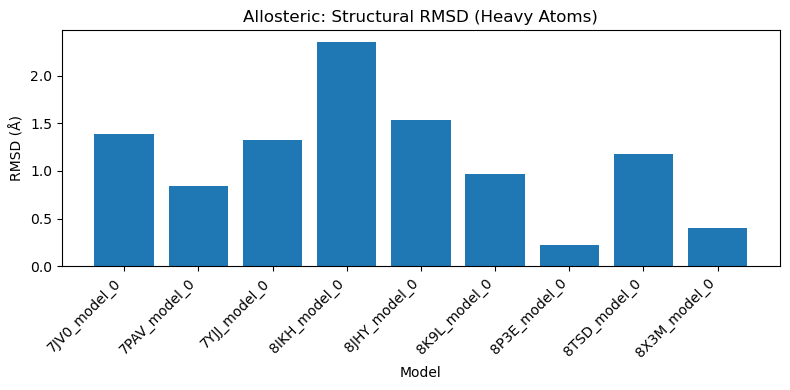

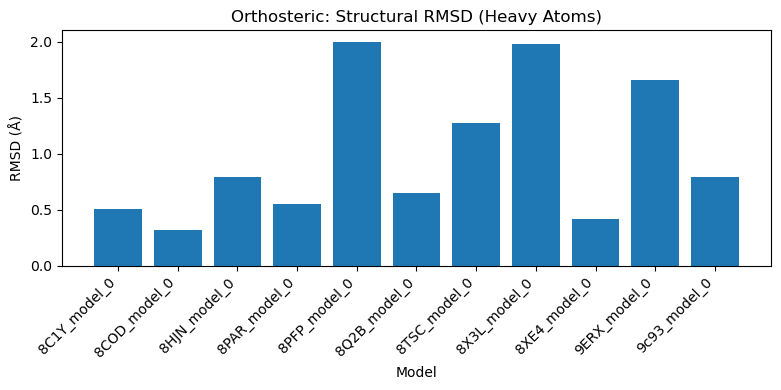

"# 3) Ligand COM Distance bar chart\nfig, ax = plt.subplots(figsize=(10, 4))\nfor site, group in df_combined.groupby('Site'):\n    ax.bar(group['model'], group['ligand_com_distance'], label=site)\nax.set_title('Ligand COM Distance by Model and Site')\nax.set_xlabel('Model')\nax.set_ylabel('COM Distance (Å)')\nax.legend()\nplt.xticks(rotation=45, ha='right')\nplt.tight_layout()\nplt.show()\n\n\n# 4) Ligand RMSD bar chart\nfig, ax = plt.subplots(figsize=(10, 4))\nfor site, group in df_combined.groupby('Site'):\n    ax.bar(group['model'], group['ligand_rmsd'], label=site)\nax.set_title('Ligand RMSD by Model and Site')\nax.set_xlabel('Model')\nax.set_ylabel('RMSD (Å)')\nax.legend()\nplt.xticks(rotation=45, ha='right')\nplt.tight_layout()\nplt.show()"

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(df_allo['model'], df_allo['rmsd_heavy'])
ax.set_title('Allosteric: Structural RMSD (Heavy Atoms)')
ax.set_xlabel('Model')
ax.set_ylabel('RMSD (Å)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 2) Structural RMSD bar chart for Orthosteric set
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(df_ortho['model'], df_ortho['rmsd_heavy'])
ax.set_title('Orthosteric: Structural RMSD (Heavy Atoms)')
ax.set_xlabel('Model')
ax.set_ylabel('RMSD (Å)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Combine the two for the ligand plots
df_combined = pd.concat([
    df_combined_allo.assign(Site='Allosteric'),
    df_combined_ortho.assign(Site='Orthosteric')
], ignore_index=True)


"""# 3) Ligand COM Distance bar chart
fig, ax = plt.subplots(figsize=(10, 4))
for site, group in df_combined.groupby('Site'):
    ax.bar(group['model'], group['ligand_com_distance'], label=site)
ax.set_title('Ligand COM Distance by Model and Site')
ax.set_xlabel('Model')
ax.set_ylabel('COM Distance (Å)')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 4) Ligand RMSD bar chart
fig, ax = plt.subplots(figsize=(10, 4))
for site, group in df_combined.groupby('Site'):
    ax.bar(group['model'], group['ligand_rmsd'], label=site)
ax.set_title('Ligand RMSD by Model and Site')
ax.set_xlabel('Model')
ax.set_ylabel('RMSD (Å)')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()"""

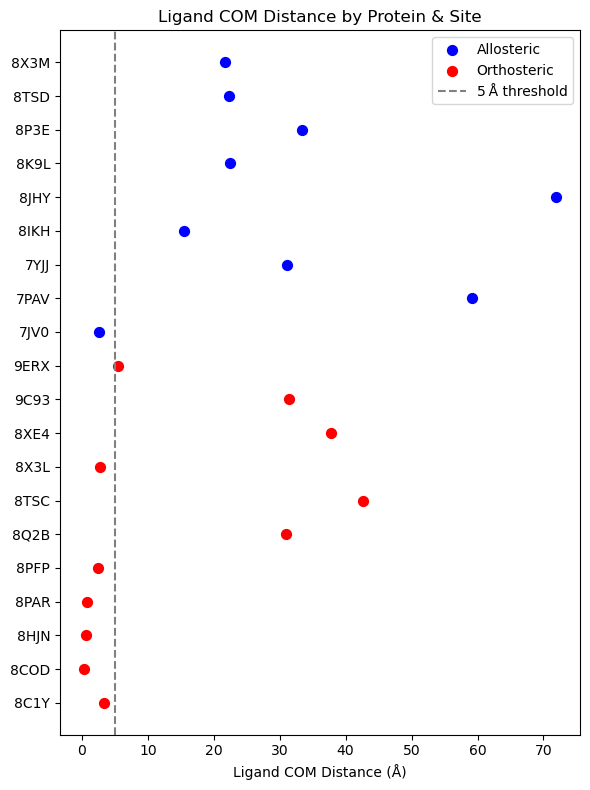

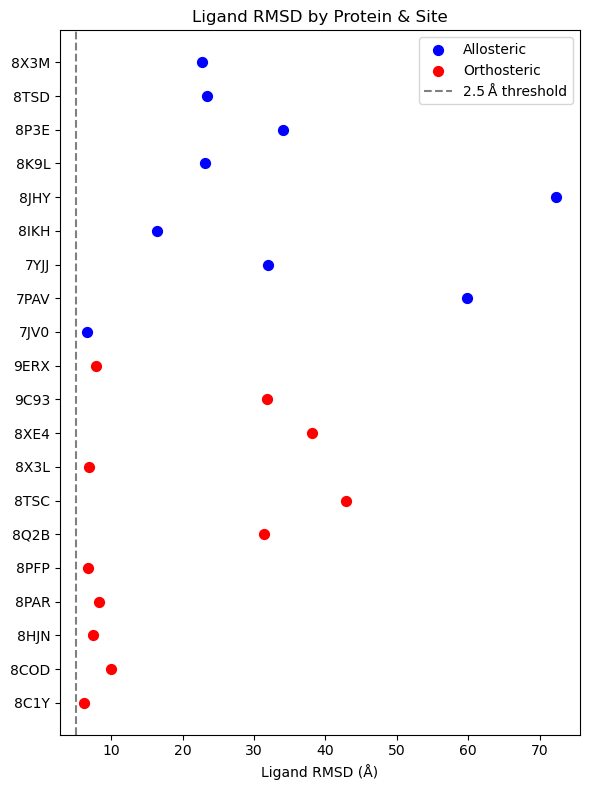

In [27]:
for df_, site in [(df_combined_allo, 'Allosteric'),
                   (df_combined_ortho, 'Orthosteric')]:
    df_['site']   = site
    # take the first 4 chars and uppercase them
    df_['pdb_id'] = df_['model'].str[:4].str.upper()

#Concatenate & map families
df = pd.concat([df_combined_allo, df_combined_ortho], ignore_index=True)
#df['family'] = df['pdb_id'].map(pdb_to_family)

df['site_order'] = df['site'].map({'Orthosteric':0, 'Allosteric':1})
df.sort_values(
    ['site_order', 'pdb_id'],
    ascending=[True, True],
    inplace=True
)
df.reset_index(drop=True, inplace=True)

df['y']     = df.index
df['label'] = df['pdb_id']

df.drop(columns='site_order', inplace=True)

colors = {'Allosteric':'blue','Orthosteric':'red'}

# COM Distance
fig, ax = plt.subplots(figsize=(6,8))
for site, grp in df.groupby('site'):
    ax.scatter(
        grp['ligand_com_distance'], grp['y'],
        c=colors[site], label=site, s=50
    )
ax.axvline(5, color='gray', linestyle='--', label='5 Å threshold')
ax.set_yticks(df['y'])
ax.set_yticklabels(df['label'])
ax.set_xlabel('Ligand COM Distance (Å)')
ax.set_title('Ligand COM Distance by Protein & Site')
ax.legend()
plt.tight_layout()
plt.show()

# Ligand RMSD
fig, ax = plt.subplots(figsize=(6,8))
for site, grp in df.groupby('site'):
    ax.scatter(
        grp['ligand_rmsd'], grp['y'],
        c=colors[site], label=site, s=50
    )
ax.set_yticks(df['y'])
ax.axvline(5, color='gray', linestyle='--', label='2.5 Å threshold')
ax.set_yticklabels(df['label'])
ax.set_xlabel('Ligand RMSD (Å)')
ax.set_title('Ligand RMSD by Protein & Site')
ax.legend()
plt.tight_layout()
plt.show()